In [1]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family = 'AppleGothic')
plt.rc('axes', unicode_minus = False)
%matplotlib inline

In [3]:
data = joblib.load(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Thd_FE.pkl'))

In [4]:
locals().update(data)

In [5]:
def MAPE(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [6]:
X.shape, y.shape

((35379, 401), (35379,))

# thd_model01

In [7]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.03, 'colsample_bytree': 0.9, 'n_estimators' : 2000,
            'max_depth': 15, 'subsample': 0.9, 'lambda': 1. , 'booster' : 'gbtree', 'silent': 1,
            'objective': 'reg:linear', 'gamma' : 0.1}

In [8]:
import random
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [42]:
def xgb_model(X, y):
    val_preds = []
    test_preds = []
    fe_info = dict()
    for k in X.columns:
        fe_info[k] = 0

    for i in range(1,13):
        # 한달에서도 랜덤 샘플 반 뽑기
        test_idx = random.sample(list(X[X['방송월'] == i].index), int(len(X[X['방송월'] == 1]) / 2))
        train_idx = set(X.index) - set(test_idx)

        train = X.loc[train_idx]
        test = X.loc[test_idx]
        y_test = y.loc[test_idx]

        x_train = train[train['방송월'] != i]
        y_train = y.loc[train[train['방송월'] != i].index]

        x_val = train[train['방송월'] == i]
        y_val = y.loc[train[train['방송월'] == i].index]

        dtrain = xgb.DMatrix(x_train, label = y_train)
        dvalid = xgb.DMatrix(x_val, label = y_val)

        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        model = xgb.train(xgb_pars, dtrain, 10000, watchlist, early_stopping_rounds=200, verbose_eval=10)
        for k, v in model.get_fscore().items():
            fe_info[k] += v

        dtest = xgb.DMatrix(test)
        val_pred = model.predict(dvalid)
        y_pred = model.predict(dtest)

        val_preds.append(MAPE(np.exp(y_val), np.exp(val_pred)))
        test_preds.append(MAPE(np.exp(y_test), np.exp(y_pred)))
        for m, arg in enumerate(zip(val_preds, test_preds), 1):
            print(f'{m}월\t', '[val]:', arg[0], '\t[test]', arg[1])
        
    return val_preds, test_preds, fe_info

In [10]:
val_preds, test_preds, fe_info3 = xgb_model(X, np.log(y))

[0]	train-rmse:15.5953	valid-rmse:15.6632
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[10]	train-rmse:11.5142	valid-rmse:11.5742
[20]	train-rmse:8.50637	valid-rmse:8.56615
[30]	train-rmse:6.29078	valid-rmse:6.3492
[40]	train-rmse:4.65897	valid-rmse:4.71412
[50]	train-rmse:3.45822	valid-rmse:3.52008
[60]	train-rmse:2.57506	valid-rmse:2.6466
[70]	train-rmse:1.92658	valid-rmse:2.0183
[80]	train-rmse:1.45002	valid-rmse:1.57106
[90]	train-rmse:1.09898	valid-rmse:1.25077
[100]	train-rmse:0.841024	valid-rmse:1.02913
[110]	train-rmse:0.65098	valid-rmse:0.873632
[120]	train-rmse:0.510973	valid-rmse:0.766707
[130]	train-rmse:0.408327	valid-rmse:0.694017
[140]	train-rmse:0.333977	valid-rmse:0.642717
[150]	train-rmse:0.2814	valid-rmse:0.608102
[160]	train-rmse:0.24395	valid-rmse:0.584128
[170]	train-rmse:0.216062	valid-rmse:0.568047
[180]	train-rmse:0.197261	valid-rmse:0.557214
[190]	train-rmse:0.

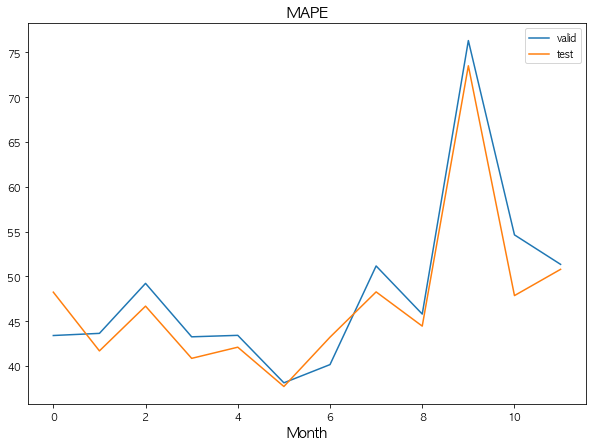

In [12]:
plt.figure(figsize = (10, 7))
plt.plot(val_preds)
plt.plot(test_preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.legend(['valid', 'test'])
plt.show()

# thd_model02 : feature importance

In [23]:
fe_info = pd.DataFrame.from_dict(fe_info3, orient='index', columns = ['importance'])

In [26]:
fe_info.sort_values('importance', ascending = False)

,importance
방송시간(분),178517
판매단가,132324
할인율,88656
상품군평균판매단가차이,84158
시간별판매랑_가구,41653
...,...
방송시간대_2,0
방송시간대_0,0
방송시간(시간)_24,0
방송시간(시간)_2,0


In [31]:
selected = fe_info.loc[fe_info['importance'] > fe_info['importance'].median()].index

In [33]:
X_selected = X[selected]

In [35]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.03, 'colsample_bytree': 0.9, 'n_estimators' : 3000,
            'max_depth': 15, 'subsample': 0.9, 'lambda': 1. , 'booster' : 'gbtree', 'silent': 1,
            'objective': 'reg:linear', 'gamma' : 0.1}

In [36]:
val_preds, test_preds, fe_info4 = xgb_model(X_selected, np.log(y))

[0]	train-rmse:15.5953	valid-rmse:15.6219
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[10]	train-rmse:11.5142	valid-rmse:11.5441
[20]	train-rmse:8.50679	valid-rmse:8.53757
[30]	train-rmse:6.29129	valid-rmse:6.32851
[40]	train-rmse:4.65956	valid-rmse:4.70864
[50]	train-rmse:3.45901	valid-rmse:3.51634
[60]	train-rmse:2.57608	valid-rmse:2.65311
[70]	train-rmse:1.92756	valid-rmse:2.02741
[80]	train-rmse:1.45092	valid-rmse:1.58114
[90]	train-rmse:1.10011	valid-rmse:1.26606
[100]	train-rmse:0.842056	valid-rmse:1.04559
[110]	train-rmse:0.651908	valid-rmse:0.894619
[120]	train-rmse:0.512036	valid-rmse:0.789572
[130]	train-rmse:0.4086	valid-rmse:0.720285
[140]	train-rmse:0.333957	valid-rmse:0.671924
[150]	train-rmse:0.280324	valid-rmse:0.639692
[160]	train-rmse:0.242522	valid-rmse:0.617544
[170]	train-rmse:0.215665	valid-rmse:0.603262
[180]	train-rmse:0.196343	valid-rmse:0.593458
[190]	train-rm

In [38]:
np.mean(val_preds), np.mean(test_preds)

(49.612311723415694, 47.57346990174716)

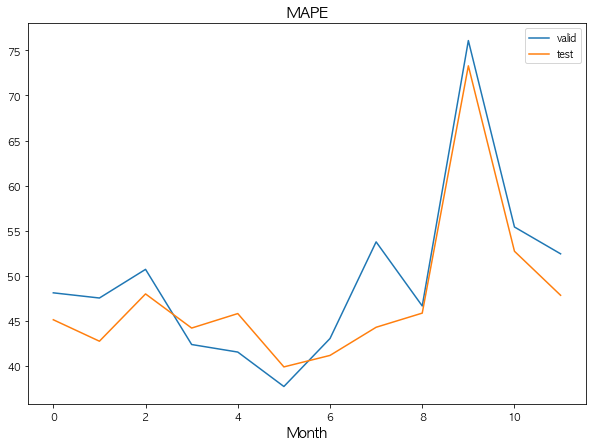

In [39]:
plt.figure(figsize = (10, 7))
plt.plot(val_preds)
plt.plot(test_preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.legend(['valid', 'test'])
plt.show()

# the_model03

In [43]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.03, 'colsample_bytree': 0.9, 'n_estimators' : 3000,
            'max_depth': 20, 'subsample': 0.9, 'lambda': 1. , 'booster' : 'gbtree', 'silent': 1,
            'objective': 'reg:linear', 'gamma' : 0.01}

In [44]:
val_preds, test_preds, fe_info5 = xgb_model(X_selected, np.log(y))

[0]	train-rmse:15.5953	valid-rmse:15.6751
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[10]	train-rmse:11.5142	valid-rmse:11.5892
[20]	train-rmse:8.50679	valid-rmse:8.57732
[30]	train-rmse:6.29128	valid-rmse:6.36235
[40]	train-rmse:4.65949	valid-rmse:4.73218
[50]	train-rmse:3.45876	valid-rmse:3.53558
[60]	train-rmse:2.57569	valid-rmse:2.66853
[70]	train-rmse:1.92698	valid-rmse:2.0446
[80]	train-rmse:1.4498	valid-rmse:1.60452
[90]	train-rmse:1.09721	valid-rmse:1.29274
[100]	train-rmse:0.836669	valid-rmse:1.07702
[110]	train-rmse:0.642938	valid-rmse:0.925391
[120]	train-rmse:0.498245	valid-rmse:0.818248
[130]	train-rmse:0.38995	valid-rmse:0.744073
[140]	train-rmse:0.309339	valid-rmse:0.692162
[150]	train-rmse:0.249156	valid-rmse:0.657539
[160]	train-rmse:0.203565	valid-rmse:0.633143
[170]	train-rmse:0.169266	valid-rmse:0.616255
[180]	train-rmse:0.142256	valid-rmse:0.604467
[190]	train-rms

In [45]:
np.mean(val_preds), np.mean(test_preds)

(47.909600306996715, 48.450461042885195)

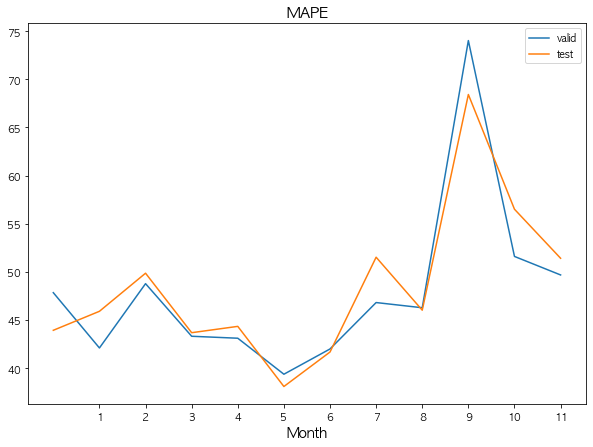

In [51]:
plt.figure(figsize = (10, 7))
plt.plot(val_preds)
plt.plot(test_preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.legend(['valid', 'test'])
plt.xticks(np.arange(1,12))
plt.show()

# Thd_model04 : 단어임베딩 변환

In [52]:
data = joblib.load(os.path.join('..', '..', '0.Data', '05_분석데이터', 'Thd_FE_v2.pkl'))

In [53]:
locals().update(data)

In [54]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.03, 'colsample_bytree': 0.9, 'n_estimators' : 3000,
            'max_depth': 20, 'subsample': 0.9, 'lambda': 1. , 'booster' : 'gbtree', 'silent': 1,
            'objective': 'reg:linear', 'gamma' : 0.01}

In [56]:
val_preds, test_preds, fe_info = xgb_model(X, np.log(y))

[0]	train-rmse:15.5953	valid-rmse:15.6234
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[10]	train-rmse:11.5143	valid-rmse:11.5309
[20]	train-rmse:8.50639	valid-rmse:8.52157
[30]	train-rmse:6.29085	valid-rmse:6.30411
[40]	train-rmse:4.6591	valid-rmse:4.66725
[50]	train-rmse:3.45821	valid-rmse:3.47587
[60]	train-rmse:2.57477	valid-rmse:2.60294
[70]	train-rmse:1.92593	valid-rmse:1.98008
[80]	train-rmse:1.44855	valid-rmse:1.54099
[90]	train-rmse:1.09637	valid-rmse:1.23541
[100]	train-rmse:0.835992	valid-rmse:1.02134
[110]	train-rmse:0.642565	valid-rmse:0.874019
[120]	train-rmse:0.498121	valid-rmse:0.771279
[130]	train-rmse:0.390049	valid-rmse:0.702959
[140]	train-rmse:0.309468	valid-rmse:0.654061
[150]	train-rmse:0.249608	valid-rmse:0.621259
[160]	train-rmse:0.204559	valid-rmse:0.599943
[170]	train-rmse:0.170181	valid-rmse:0.584549
[180]	train-rmse:0.143631	valid-rmse:0.573868
[190]	train-r

In [57]:
np.mean(val_preds), np.mean(test_preds)

(47.71620190398121, 47.66624583304767)

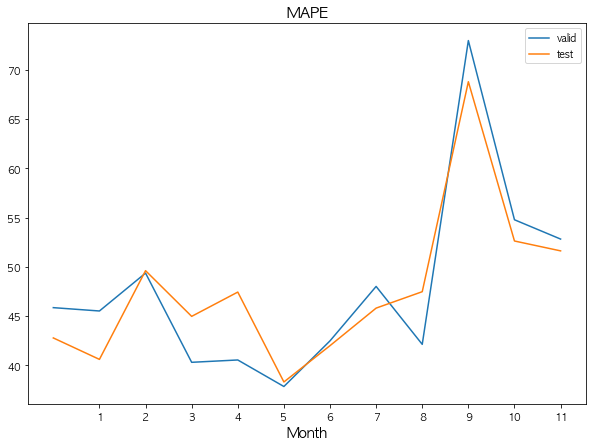

In [58]:
plt.figure(figsize = (10, 7))
plt.plot(val_preds)
plt.plot(test_preds)
plt.xlabel('Month', fontsize = 14)
plt.title('MAPE', fontsize = 15)
plt.legend(['valid', 'test'])
plt.xticks(np.arange(1,12))
plt.show()